<a href="https://colab.research.google.com/github/jiin124/2021_2_SAI_ML/blob/main/%EB%B6%84%EB%A5%98%EC%8B%A4%EC%8A%B5_%EC%BA%90%EA%B8%80_%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EC%82%AC%EA%B8%B0_%EA%B2%80%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 캐글 신용카드 사기 검출



In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [37]:
os.environ['KAGGLE_USERNAME']='jiinpp'
os.environ['KAGGLE_KEY']='b06d525a9f66198051ccb648b091778a'

In [38]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [39]:
!unzip '*.zip'

Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: creditcard.csv          


In [40]:
df=pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


time피처의 경우는 데이터 생성 관련한 작업용 속성으로서 큰 의미가 없기 때문에 삭제하겠다. 
class의 경우 0이 정상 1의 경우 ㅏ기이다. 

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [42]:
from sklearn.model_selection import train_test_split

#인자로 입력받은 데이터프레임을 time 컬럼만 삭제하고 복사된 dataFrame 반환
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  df_copy.drop('Time',axis=1,inplace=True)
  return df_copy

 데스트 데이터 세트를 전체의 30%인 stratified 방식으로 추출해 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 분포도를 서로 동일하게 만든다. 

In [43]:
def get_train_test_dataset(df=None):
  #인자로 입력된 데이터프레임의 사전 데이터 가공이 완료된 복사 데이터 프레임 반환
  df_copy=get_preprocessed_df(df)
  #데이터프레임의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features=df_copy.iloc[:,:-1]
  y_target=df_copy.iloc[:,-1]
  #train_test_split()으로 학습과 테스트 데이터 분할, stratify=y_target으로 stratified 기반 분할
  X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=0,stratify=y_target)
  #학습과 테스트 데이터 세트 반환
  return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=get_train_test_dataset(df)

In [44]:
print("학습 데이터 레이블 값 비율")
print(y_train.value_counts()/y_train.shape[0]*100)
print("테스트 데이터 레이블 값 비율")
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


## 모델링

In [45]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,f1_score

In [46]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

### 로지스틱회귀

In [47]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba=lr_clf.predict_proba(X_test)[:,1]

#3장에서 사용한 get_clf_eval()을 이용해 평가 수행
get_clf_eval(y_test,lr_pred,lr_pred_proba)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


오차행렬
[[85282    13]
 [   64    84]]
정확도: 0.9991, 정밀도: 0.8660, 재현율: 0.5676, F1: 0.6857, AUC:0.7837


### LightGBM

In [48]:
#인자로 사이킷런의 estimator객체와 학습/테스트 데이터 세트를 입력받아 학습예측평가 수행
def get_model_train_eval(model, ftr_train=None,ftr_test=None,tgt_train=None,tgt_test=None):
  model.fit(ftr_train,tgt_train)
  pred=model.predict(ftr_test)
  pred_proba=model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test,pred,pred_proba)


In [49]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

오차행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC:0.8783


## 데이터 분포도 변환 후 모델 학습/예측/평가

이번에는 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트해보겠다. 먼저 creditcard.csv의 중요 피처 갑스이 분포도를 살펴보자. 로지스틱 회귀는 선형 모델로 대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호한다. amount 피처는 신용카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다. Amount 피처의 분포도를 확인해보겠다. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


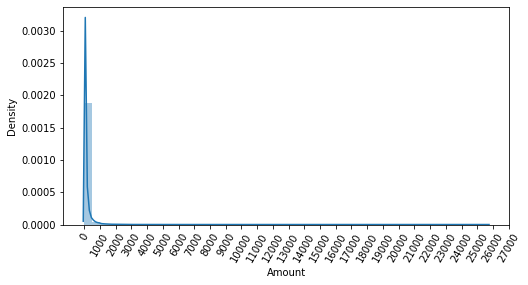

In [50]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.distplot(df['Amount'])

Amount 극 카드 사용금액이 100불 이하인 데이터가 대부분이며, 27000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있다. amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정해보겠다. 그리고 get_processed_df()를 사이킷런의 standardscaler 클래스를 이용해 amount 피처를 정규 분포 형태로 변환하는 코드로 변경한다. 

In [63]:
from sklearn.preprocessing import StandardScaler

#사이킷런의 stadardScaler를 이용해 정규 분포 형태로 amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  scaler=StandardScaler()
  amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  #변환된 Amount를 Amount_scaled로 피처 변경 후 dataframe맨 앞 칼럼으로 입력.
  df_copy.insert(0,'Amount_scaled',amount_n)
  #기존 time,amount 피처 삭제
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [64]:
#Amount를 정규 분포 형태로 변환후 로지스틱 회귀 및 LightGBM 수행
X_train,X_test,y_train,y_test=get_train_test_dataset(df)

print("로지스틱 회귀 예측 성능")
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)
print("lightGBM 얘측 성능 ")
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

로지스틱 회귀 예측 성능
오차행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC:0.8040
lightGBM 얘측 성능 
오차행렬
[[85112   183]
 [  126    22]]
정확도: 0.9964, 정밀도: 0.1073, 재현율: 0.1486, F1: 0.1246, AUC:0.5733


크게 개선되지는 않았다. 그래서 로그변환을 해보겠다. 

In [61]:
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  #넘파이의 log1p()를 이용해 amount를 로그 변환
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [62]:
X_train,X_test,y_train,y_test=get_train_test_dataset(df)


print("로지스틱 회귀 예측 성능")
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print("lightGBM 얘측 성능 ")
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

로지스틱 회귀 예측 성능
오차행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC:0.8006
lightGBM 얘측 성능 
오차행렬
[[85148   147]
 [  147     1]]
정확도: 0.9966, 정밀도: 0.0068, 재현율: 0.0068, F1: 0.0068, AUC:0.5025


## 이상치 데이터 제거 후 모델 학습/예측/평가

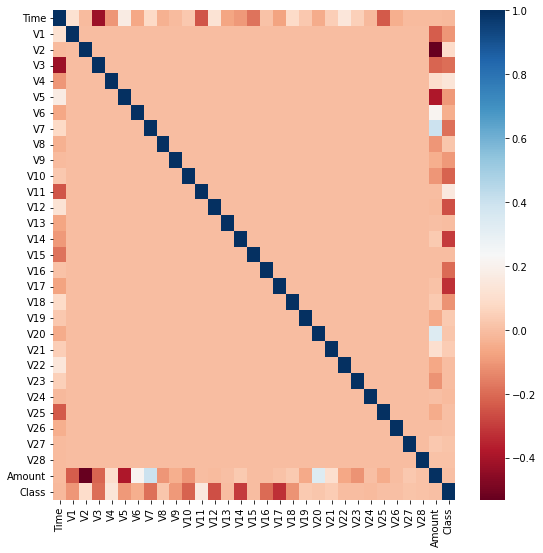

In [65]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr=df.corr()
sns.heatmap(corr,cmap='RdBu')

class 피처와 음의 상관관계를 가진은 V14,V17이다. 이중에서 V14에 대해서만 이상치를 찾아서 제거해보겠다. 그리고 검출된 이상치를 삭제하겠다. 

In [72]:
import numpy as np

def get_outlier(df=None,column=None,weight=1.5):
  #froud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위지점을 np.percentile로 구함
  fraud=df[df['Class']==1][column]
  quantile_25=np.percentile(fraud.values,25)
  quantile_75=np.percentile(fraud.values,75)
  #IQR을 구하고 IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
  iqr=quantile_75-quantile_25
  iqr_weight=iqr*weight
  lowest_val=quantile_25-iqr_weight
  highest_val=quantile_75+iqr_weight
  #최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 dataframe index반환
  outlier_index=fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index


In [73]:
outlier_index=get_outlier(df=df,column='V14',weight=1.5)

In [74]:
print('이상치 데이터 인덱스 : ',outlier_index)

이상치 데이터 인덱스 :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [75]:
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  #넘파이의 log1p()를 이용해 amount를 로그 변환
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)

  #이상치 데이터 삭제하는 로직 추가
  outlier_index=get_outlier(df=df_copy,column='V14',weight=1.5)
  df_copy.drop(outlier_index,axis=0,inplace=True)
  return df_copy


X_train,X_test,y_train,y_test=get_train_test_dataset(df)


print("로지스틱 회귀 예측 성능")
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print("lightGBM 얘측 성능 ")
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

로지스틱 회귀 예측 성능
오차행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.8355
lightGBM 얘측 성능 
오차행렬
[[85179   116]
 [  117    29]]
정확도: 0.9973, 정밀도: 0.2000, 재현율: 0.1986, F1: 0.1993, AUC:0.5986


## SMOTE 오벌 샘플링 적용 후 모델 학습/예측/평가

In [76]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over,y_train_over=smote.fit_sample(X_train,y_train)
print('smote 적용 전 학습용 피처.레이블 데이터 세트 : ',X_train.shape,y_train.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


smote 적용 전 학습용 피처.레이블 데이터 세트 :  (199362, 29) (199362,)


In [77]:
print('smote 적용 후 학습용 피처.레이블 데이터 세트 : ',X_train_over.shape,y_train_over.shape)
print('Smote 적용 후 레이블 값 분포:\n ',pd.Series(y_train_over).value_counts())

smote 적용 후 학습용 피처.레이블 데이터 세트 :  (398040, 29) (398040,)
Smote 적용 후 레이블 값 분포:
  1    199020
0    199020
dtype: int64


smote 오버샘플링 적용 후 데이터가 증식됐다. 거의 2배나... 그리고 레이블 값이 0과 1의 분포가 동일하게 생성됐다. 

이제 여기다가 로지스틱 회귀를 적용해보겠다

In [78]:
lr_clf=LogisticRegression()
#ftr_train 과 tgt_train, 인자값이 smote 증식된 X_train_over,y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)

오차행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9485


이게 머선일,,,, 재현율은 엄청 크게 증가했는데, 정밀도는 최악임... 그래서 이런 정밀도로는 현실 업무에 적용 ㄴㄴ . 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 class=1을 학습하면서 실제 데이터 세트에서 예측을 지나치게 class=1로 적용해 정밀도가 급격히 떨어지게 된것. 

In [82]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test,pred_proba_c1):
  #threshold ndarry와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions,recalls,thresholds=precision_recall_curve(y_test,pred_proba_c1)

  #X축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 plot 수행, 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary=thresholds.shape[0]
  plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
  plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')

  #threshold 값 X축의 scale을 0.1 단위로 변경
  start,end=plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  #X축,y축 label과 legend 그리고 grid 설정
  plt.xlabel('Threshold value')
  plt.ylabel('Precision and Recall value')
  plt.legend()
  plt.grid()

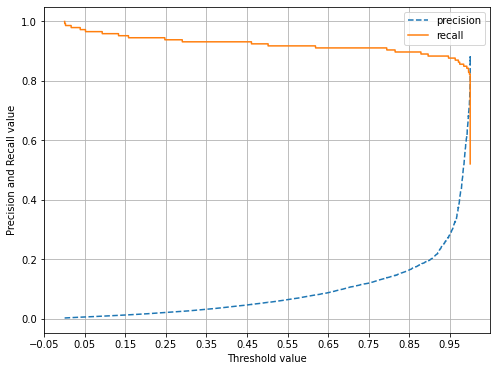

In [83]:
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

LightGBM 적용

In [84]:
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train_over,ftr_test=X_test,
                     tgt_train=y_train_over,tgt_test=y_test)

오차행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493, F1: 0.8889, AUC:0.9246


재현율이 이상치만 제거했을 때보다는 조금 높아졌다. 하지만 정밀도는 전보다 낮아졌다. smote를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적이다. 좋은 smote패키지일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출수 있도록 효과적으로 데이터를 증식한다. 